In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
Data_clean = pd.read_excel('data_balanced.xlsx')
#print(data.head())

In [3]:
Data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 12 columns):
Age                    1812 non-null int64
Amount_netCN           1812 non-null float64
TermOfPaymentDays      1812 non-null int64
GDP by State           1812 non-null int64
Unemployment rate      1812 non-null float64
DefaultStatus          1812 non-null int64
month1                 1812 non-null int64
month2                 1812 non-null int64
month3                 1812 non-null int64
month4                 1812 non-null int64
month5                 1812 non-null int64
Feq_default_ZipCode    1812 non-null float64
dtypes: float64(3), int64(9)
memory usage: 170.0 KB


In [4]:
# Print a null value column array
print(Data_clean.columns[Data_clean.isnull().any()])

Index([], dtype='object')


In [5]:
# Create the X and y data sets
X = Data_clean.loc[:, Data_clean.columns != "DefaultStatus"]
y = Data_clean[["DefaultStatus"]]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs')
scaler = MinMaxScaler()
pipeline_lg = make_pipeline(scaler, clf_logistic)
pipeline_lg.fit(X_train, np.ravel(y_train))

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [6]:
# Create predictions of probability for loan status using test data
preds = pipeline_lg.predict_proba(X_test)  #preds is proba

# Create dataframes predictions,and  true labels
preds_df = pd.DataFrame(preds[:,1][:], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

DefaultStatus  prob_default
0                0      0.153214
1                1      0.999827
2                0      0.033704
3                1      0.589399
4                1      0.581817
..             ...           ...
720              0      0.011257
721              0      0.106777
722              0      0.009152
723              0      0.147475
724              1      0.561935

[725 rows x 2 columns]


In [7]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default']) #preds_df is proba

# Reassign loan status based on the threshold
preds_df['DefaultStatus'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.25 else 0)  #cut-off is 0.25 #preds_df['DefaultStatus'] is predicted DefaultStatus, not real DefaultStatus from test set. Confusion matrix below is based on preds_df['DefaultStatus'] --predicted DefaultStatus

# Print the row counts for each loan status
print(preds_df['DefaultStatus'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['DefaultStatus'], target_names=target_names))

print(confusion_matrix(y_test,preds_df['DefaultStatus']))

1    441
0    284
Name: DefaultStatus, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.99      0.79      0.88       354
     Default       0.83      0.99      0.91       371

    accuracy                           0.90       725
   macro avg       0.91      0.89      0.89       725
weighted avg       0.91      0.90      0.89       725

[[281  73]
 [  3 368]]


In [8]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y_test,preds_df['DefaultStatus']))

(array([0.98943662, 0.83446712]), array([0.79378531, 0.99191375]), array([0.88087774, 0.90640394]), array([354, 371], dtype=int64))


In [9]:
# Print the first two numbers from the report
print(precision_recall_fscore_support(y_test,preds_df['DefaultStatus'])[0])

[0.98943662 0.83446712]


In [10]:
# Print the accuracy score the model
print(pipeline_lg.score(X_test, y_test))

0.8772413793103448


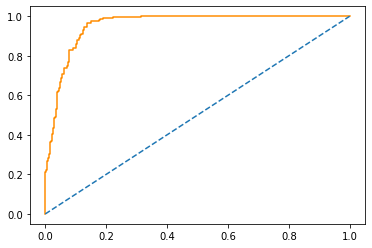

0.9548251024106477


In [11]:
# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]  # #preds is proba
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)  #prob_default is prob
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(auc)

In [12]:
#Hyperparameter tuning

In [13]:
X = Data_clean.loc[:, Data_clean.columns != "DefaultStatus"]
y = Data_clean[["DefaultStatus"]]
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.4, random_state=123)

In [14]:

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression() #solver='lbfgs' , penalty = 'l2'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
#c_space = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['lbfgs']  #, 'liblinear'
param_grid = {'C': c_space, 'solver':solver}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(estimator=clf_logistic, param_grid=param_grid, cv=5 , scoring='roc_auc') 

# Fit it to the data
logreg_cv.fit(X_train, np.ravel(y_train))


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'solver': ['lbfgs'

In [15]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 163789.3706954068, 'solver': 'lbfgs'}
Best score is 0.9660227614332627


In [16]:
#pipeline_lg = logreg_cv
pipeline_lg = LogisticRegression(**logreg_cv.best_params_)
pipeline_lg.fit(X_train, np.ravel(y_train))

LogisticRegression(C=163789.3706954068, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
pipeline_lg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=163789.3706954068, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [18]:
# Create predictions of probability for loan status using test data
preds = pipeline_lg.predict_proba(X_test)  #preds is proba

# Create dataframes predictions,and  true labels
preds_df = pd.DataFrame(preds[:,1][:], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

DefaultStatus  prob_default
0                0  5.745976e-02
1                1  9.999998e-01
2                0  2.667638e-08
3                1  7.470661e-01
4                1  6.813000e-01
..             ...           ...
720              0  2.752654e-09
721              0  3.071148e-02
722              0  2.043555e-09
723              0  5.330702e-02
724              1  6.502317e-01

[725 rows x 2 columns]


In [19]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default']) #preds_df is proba

# Reassign loan status based on the threshold
preds_df['DefaultStatus'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.25 else 0)  #cut-off is 0.25 #preds_df['DefaultStatus'] is predicted DefaultStatus, not real DefaultStatus from test set. Confusion matrix below is based on preds_df['DefaultStatus'] --predicted DefaultStatus

# Print the row counts for each loan status
print(preds_df['DefaultStatus'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['DefaultStatus'], target_names=target_names))

1    416
0    309
Name: DefaultStatus, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.97      0.84      0.90       354
     Default       0.87      0.97      0.92       371

    accuracy                           0.91       725
   macro avg       0.92      0.91      0.91       725
weighted avg       0.92      0.91      0.91       725



In [20]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y_test,preds_df['DefaultStatus']))

(array([0.96763754, 0.86778846]), array([0.84463277, 0.97304582]), array([0.90196078, 0.91740788]), array([354, 371], dtype=int64))


In [21]:
# Print the first two numbers from the report
print(precision_recall_fscore_support(y_test,preds_df['DefaultStatus'])[0])

[0.96763754 0.86778846]


In [22]:
# Print the accuracy score the model
print(pipeline_lg.score(X_test, y_test))

0.8896551724137931


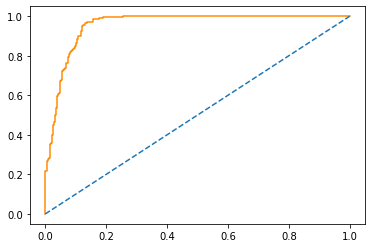

0.9557159608326862


In [23]:
# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]  # #preds is proba
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)  #prob_default is prob
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(auc)

In [24]:
#save model
import pickle
filename = 'logistic_model.sav'
pickle.dump(pipeline_lg, open(filename, 'wb'))

In [25]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(X_test)

array([[9.42540242e-01, 5.74597578e-02],
       [1.95221055e-07, 9.99999805e-01],
       [9.99999973e-01, 2.66763793e-08],
       ...,
       [9.99999998e-01, 2.04355507e-09],
       [9.46692978e-01, 5.33070225e-02],
       [3.49768277e-01, 6.50231723e-01]])